##1-İMPORTİNG LİBRARİES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

##2-Build Graphic Function

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

##3-Build Trend Function

In [ ]:
def trend(time,slope=0):
  return time*slope

##4-Build Seasonal Patterns

> Ne kadarı hangi grafik ne kadar diğer grafik olduğunu belli ediyoruz



In [ ]:
def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))

##5-Build Seasonality Function

In [ ]:
def seasonality(time,period,amplitude=1,phase =0):
  season_time =((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

##6 - Build White Noise Func

In [ ]:
def white_noise(time,noise_level=1,seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))* noise_level

##7-Build Sequential window dataset func

In [ ]:
def sequential_window_dataset(series,window_size):
  series = tf.expand_dims(series,axis = 1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1,shift = window_size,drop_remainder = True)
  ds = ds.flat_map(lambda w : w.batch(window_size + 1))
  ds = ds.map(lambda w : (w[:-1],w[1:]))
  return ds.batch(1).prefetch(1)

##8-İmplemeting Funcs



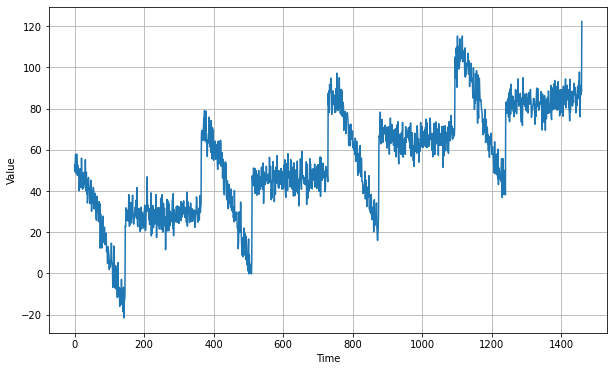

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time,slope) + seasonality(time , period = 365,amplitude = amplitude)


noise_level = 5
noise = white_noise(time,noise_level,seed=42)


series += noise

plt.figure(figsize = (10,6))
plot_series(time,series)
plt.show()

##9 Determining the Split Tİme (test - Valid interval)

In [ ]:
split_time = 1000
time_train= time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

##10- Restarting Callback Func

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

##11- LTSM RNN ForeCasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size = 30
train_set = sequential_window_dataset(x_train,window_size)


model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences = True,stateful = True,
                      batch_input_shape = [1,None,1]),
    
    keras.layers.LSTM(100,return_sequences = True,stateful = True),

    keras.layers.Dense(1),
    keras.layers.Lambda(lambda  x : x * 200.0)
])


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(
    loss=keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 5s 22ms/step - loss: 46.8590 - mae: 47.3590 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 21ms/step - loss: 39.7605 - mae: 40.2603 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 1s 20ms/step - loss: 31.7681 - mae: 32.2671 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 1s 40ms/step - loss: 23.4556 - mae: 23.9519 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 1s 20ms/step - loss: 17.4712 - mae: 17.9637 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 1s 33ms/step - loss: 15.3970 - mae: 15.8898 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 1s 29ms/step - loss: 14.5345 - mae: 15.0283 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 1s 20ms/step - loss: 14.1241 - mae: 14.6168 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 1s 20ms/step - loss: 13.8014 - mae:

(1e-08, 0.0001, 0.0, 30.0)

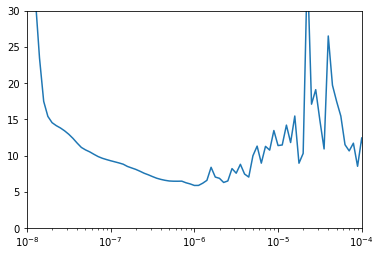

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 6s 64ms/step - loss: 3583.5044 - mae: 3584.0049 - val_loss: 6104.0571 - val_mae: 6104.5562
Epoch 2/500
33/33 [==============================] - 2s 50ms/step - loss: 7321.0176 - mae: 7321.5176 - val_loss: 10198.0176 - val_mae: 10198.5166
Epoch 3/500
33/33 [==============================] - 2s 69ms/step - loss: 10597.2891 - mae: 10597.7861 - val_loss: 1868.5349 - val_mae: 1869.0347
Epoch 4/500
33/33 [==============================] - 1s 27ms/step - loss: 9621.6660 - mae: 9622.1680 - val_loss: 12753.6240 - val_mae: 12754.1230
Epoch 5/500
33/33 [==============================] - 1s 42ms/step - loss: 8852.1230 - mae: 8852.6240 - val_loss: 803.1707 - val_mae: 803.6707
Epoch 6/500
33/33 [==============================] - 1s 32ms/step - loss: 7013.5396 - mae: 7014.0391 - val_loss: 3546.8394 - val_mae: 3547.3394
Epoch 7/500
33/33 [==============================] - 1s 25ms/step - loss: 15655.0938 - mae: 15655.5938 - val_loss: 21755.6758 - val_

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 3s 3s/step


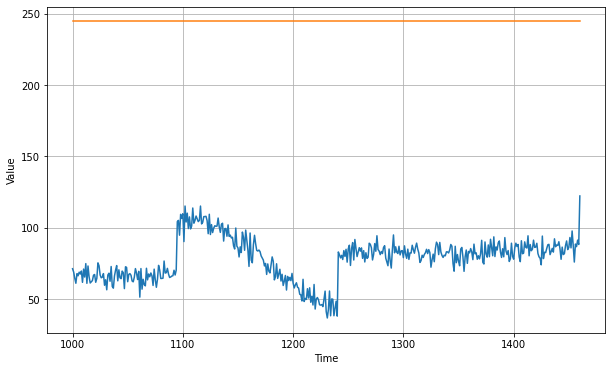

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

166.10175